# Plotting and Analyzing the Helium-Graphene Potential

In [1]:
# %load ../include/header.py
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Some helper and analysis functions

In [2]:
import layerutils
importlib.reload(layerutils)
from layerutils import lab,vals,texformat

## The Graphene Lattice

In [3]:
# lattice vectors
aₒ = 1.42
a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])

#√3 x √3
θ = π/6
R = np.array([[np.cos(θ),-np.sin(θ)],[np.sin(θ),np.cos(θ)]])
α = np.matmul(R,np.sqrt(3)*a)

# basis vectors
b = aₒ*np.array([[np.sqrt(3)/2,0],[1/2,1]])

# Box size
L = [8,8]

In [4]:
C_positions = []
G_centers = []
hex_centers = []
for n1 in range(-8,8):
    for n2 in range(-8,8):
        G_centers.append(n1*α[:,0] + n2*α[:,1])
        C_positions.append(n1*a[:,0] + n2*a[:,1] + b[:,0])
        C_positions.append(n1*a[:,0] + n2*a[:,1] + b[:,1])
        hex_centers.append(n1*a[:,0] + n2*a[:,1])

C_positions = np.array(C_positions)
G_centers = np.array(G_centers)
hex_centers = np.array(hex_centers)

C_positions = np.array(C_positions[np.intersect1d(np.where(np.abs(C_positions[:,0])<L[0])[0],np.where(np.abs(C_positions[:,1])<L[1])[0])])
He_positions = np.array(G_centers[np.intersect1d(np.where(np.abs(G_centers[:,0])<L[0])[0],np.where(np.abs(G_centers[:,1])<L[1])[0])])
hex_centers = np.array(hex_centers[np.intersect1d(np.where(np.abs(hex_centers[:,0])<L[0])[0],np.where(np.abs(hex_centers[:,1])<L[1])[0])])

## The xy-Averaged Value of the Potential

In [5]:
def V0_graphene(z,ε=16.961,σ=2.643):
    aₒ = 1.42
    A = 3*np.sqrt(3)*aₒ*aₒ/2
    return (4*π/A)*ε*σ*σ*( (2/5)*(σ/z)**10 - (σ/z)**4 )

from scipy.special import zeta as ζ
def V0_graphite(z,ε=16.24,σ=2.74):
    aₛ = 5.24
    d = 3.37
    return ((4*π*ε*σ**6)/(aₛ*d**4))*( (2/5)*(σ/d)**6*ζ(10,z/d) - ζ(4,z/d) )

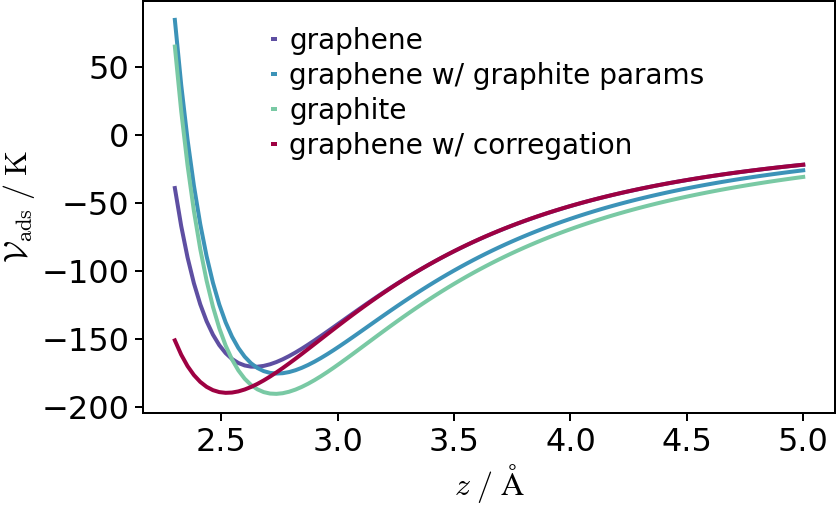

In [6]:
z = np.linspace(2.3,5,100)
aₒ = 1.42
V_64 = np.vectorize(gt.V_64)
σ,ε = gt.get_LJ_parameters(0.0)

with plt.style.context(plot_style['notebook']):
    plt.plot(z,V0_graphene(z), label='graphene')
    plt.plot(z,V0_graphene(z,ε=16.24,σ=2.74), label='graphene w/ graphite params')
    plt.plot(z,V0_graphite(z), label='graphite')
    plt.plot(z,V_64(0,σ,ε,0,0,z), color=colors[-1], label='graphene w/ corregation')
    plt.xlabel(r'$z \;/\; \mathrm{\AA}$')
    plt.ylabel(r'$\mathcal{V}_{\rm ads} \;/\; \mathrm{K}$')
    
    plt.legend()

We analyze the relative strength of the potentials by looking at them at the minima.

In [7]:
np.min(V0_graphene(z))

-170.45768322427193

In [8]:
np.min(V0_graphene(z))/np.min(V0_graphite(z))

0.8952164880156326

## The Corrugation Potential
First we analyze the full potential at a fixed slice.  We use the `graphenetools` library.

In [7]:
Vmin = gt.V_64(0.0,σ,ε,0,0,2.7)
Vmax = gt.V_64(0.0,σ,ε,0,1.42,2.7)
Vsp = gt.V_64(0.0,σ,ε,np.sqrt(3)*aₒ/2,0,2.7)
print(f'Vmin = {Vmin:.2f} K')
print(f'Vmax-Vmin = {Vmax-Vmin:.2f} K')
print(f'Vsp-Vmmin = {Vsp-Vmin:.2f} K')

Vmin = -178.66 K
Vmax-Vmin = 15.19 K
Vsp-Vmmin = 12.73 K


In [8]:
def V(x,y):
    aₒ = 1.42
    Vmax,Vsp = -25,-23
    A = Vmax/9
    B = (9*Vsp-8*Vmax)/72
    t1 = A*2*(np.cos(2*π/(3*aₒ)*(np.sqrt(3)*x-y)) + np.cos(4*π*y/(3*aₒ)) + np.cos(2*π/(3*aₒ)*(np.sqrt(3)*x+y)))  
    t2 = B*2*(np.cos(4*π*x/(np.sqrt(3)*aₒ)) + 2*np.cos(2*π*x/(np.sqrt(3)*aₒ))*np.cos(2*π*y/aₒ))
    return t1+t2

In [11]:
V(np.sqrt(3)*aₒ/2,0),V(0,aₒ)

(5.75, 7.749999999999999)

In [13]:
from mpl_toolkits.mplot3d import Axes3D,art3d
from matplotlib.textpath import TextPath
import matplotlib.transforms as mtransforms
from matplotlib.patches import PathPatch
grey = colortools.hex_to_rgb('#888888')


#3D plotting tools
def lims(mplotlims):
    scale = 1.021
    offset = (mplotlims[1] - mplotlims[0])*scale
    return mplotlims[1] - offset, mplotlims[0] + offset
    
def text_on_the_wall(ax, xyz, s, zdir="z", size=None, angle=0, usetex=False, center=True, 
                     aspect_ratio=1.0, **kwargs):
    x, y, z = xyz
    if zdir == "y":
        xy1, z1 = (x, z), y
    elif zdir == "x":
        xy1, z1 = (y, z), x
    else:
        xy1, z1 = (x, y), z

    text_path = TextPath((0, 0), s, size=size, usetex=usetex)
    
    #Scale by aspect ratio
    scale_path = mtransforms.Affine2D().scale(1.0, sy=aspect_ratio)
    text_path = scale_path.transform_path(text_path)

    #Get bbox to center text
    bbox = text_path.get_extents()
    bbox_points = bbox.get_points()
    _b = bbox_points.sum(axis=0)/2
    
    if center == True:
        trans = mtransforms.Affine2D().rotate(angle).translate(xy1[0] - _b[0], xy1[1] - _b[1])
    else:
        trans = mtransforms.Affine2D().rotate(angle).translate(xy1[0], xy1[1] - _b[1])
  
    tp = trans.transform_path(text_path)
    p1 = PathPatch(tp, **kwargs)
    ax.add_patch(p1)

    art3d.pathpatch_2d_to_3d(p1, z=z1, zdir=zdir)

def test_3D_wall_text(fig_ax=None, mplstylefile="default", left_wall_text_xy=(0.5, 0.95), 
                      right_wall_text_xy=(0.5, 0.95), left_wall_text_size = 0.5, 
                      right_wall_text_size = 0.5, left_wall_text=None, right_wall_text=None, 
                      xlabel=None, ylabel=None, zlabel=None, dpi=None, add_pane_edge=True, 
                      pane_edge_color="#c8c8c8", pane_face_color="#f0f0f5", 
                      horizontal_shift=.5, vertical_shift=-0.12, labelpad=[10.0,10.0,17.0], 
                      ztickpad=10.0, figsize=None, xlim=None, ylim=None, zlim=None, plot_filename=None,
                      surf_kwargs={},**kwargs):

    with plt.style.context(mplstylefile):
        if fig_ax:
            fig, ax = fig_ax
        else:
            fig = plt.figure(figsize=(3.4,2.8),dpi=dpi, constrained_layout=True)
            ax = fig.add_subplot(111, projection='3d')
            
        # Remove grid lines
        ax.grid(False)
        
        aₒ = 1.42
        
        # Remove ticks
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_zticks([])

        # Remove tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

        
        # Some default kwargs for plot_surface
        _surf_kwargs = {"cmap":"Spectral_r", "linewidth":0, "antialiased":False, 
                        "alpha":1.0, 'rasterized':True}
        
        # Overwrite surface kwargs with input parameters
        for key in surf_kwargs.keys():
            _surf_kwargs[key] = surf_kwargs[key]

        #### Steele Potential #################################
        # Make data.
   
        X = np.linspace(-aₒ*np.sqrt(3), aₒ*np.sqrt(3), 501)
        Y = np.linspace(-aₒ*np.sqrt(3), aₒ*np.sqrt(3), 501)
        X, Y = np.meshgrid(X, Y)
        Vs = V(X,Y)

        # Plot the surface.
        surf = ax.plot_surface(Y, X, Vs, rstride=1, cstride=1,zorder=-1, **_surf_kwargs)
        
        ### Tunneling Paths ###################################
        t1 = np.linspace(0,a[0,1]-0.05,1000)
        t2 = np.linspace(0,a[1,1]+0.05,1000)
        t = np.linspace(0,aₒ*np.sqrt(3),1000)
        zs = V(t,np.zeros_like(t))
        ax.plot(np.zeros_like(t),t,zs, color='k', lw=1, ls='-', alpha=1, zorder=10, zdir='z')
        
        t = np.linspace(-aₒ/2,aₒ/2,1000)
        zs = V(aₒ*np.sqrt(3)/2,t)
        ax.plot(t,aₒ*np.sqrt(3)/2*np.ones_like(t),zs, lw=1, ls='-', alpha=1, 
                zorder=9, zdir='z', color=grey)
        
        ### Special Points #####################################
        ax.plot([0,0],[0,aₒ*np.sqrt(3)],[V(0,0),V(0,0)], lw=0, marker='o', mfc='k', linestyle=None, alpha=1, 
                zorder=10, zdir='z', color='k', markersize=2)
        
        ax.plot([t[0],t[-1]],[aₒ*np.sqrt(3)/2,aₒ*np.sqrt(3)/2],[zs[-1],zs[-1]], lw=0, marker='o', mfc=grey, linestyle=None, alpha=1, 
                zorder=10, zdir='z', color=grey, markersize=2)
        
        
        ## Create an outline ####################################
        ax.plot(Y[:,0], X[:,0], Vs[:,0], lw=0.25, color='k', zorder=100)
        ax.plot(Y[:,-1], X[:,-1], Vs[:,-1], lw=0.25, color='k', zorder=100)
        
        ax.plot(Y[0,:], X[0,:], Vs[0,:], lw=0.25, color='k', zorder=100)
        ax.plot(Y[-1,:], X[-1,:], Vs[-1,:], lw=0.25, color='k', zorder=100)

        ##########################################################
        
        # Add labels
        ax.text(0, -0.5, V(0,0), r'${\mathcal{V}}_{\rm He-\graphene}^{\rm min}$', color='k', 
                zorder=200, fontsize=7)
        ax.text(-b[0,0]-0.0, b[1,0]+0.5, 1.5, r'${\mathcal{V}}_{\rm He-\graphene}^{\rm max}$', color='k', 
                zorder=200, fontsize=7, ha='center')
        
        ax.text(-0.25, b[1,0]+0.9, 1.6, r'${\mathcal{V}}_{\rm He-\graphene}^{\rm sp}$', color='k', 
                zorder=200, fontsize=7, ha='center')
        
        # Change limits if provided
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)    
        if zlim:
            ax.set_zlim(zlim)
        
        # Set labels from input parameters xlabel, ylabel, zlabel, and labelpad
        # labelpad is array like [xlabelpad,ylabelpad,zlabelpad]        
    
        ax.set_xlabel(xlabel, labelpad=labelpad[0])
        ax.set_ylabel(ylabel, labelpad=labelpad[1])
        ax.set_zlabel(zlabel, labelpad=labelpad[2])

        # pad z-axis ticks with ztickpad
        ax.tick_params(axis='z', which='major', pad=ztickpad)

        # Adds pane edge to front left of box
        if add_pane_edge:
            xlims, ylims, zlims = lims(ax.get_xlim()), lims(ax.get_ylim()), lims(ax.get_zlim())
            i = np.array([xlims[0], ylims[0], zlims[0]])
            f = np.array([xlims[0], ylims[0], zlims[1]])
            p = art3d.Poly3DCollection(np.array([[i, f]]))

            p.set_color(pane_edge_color)
            ax.add_collection3d(p)

        #Set pane edge color
        ax.xaxis.pane.set_edgecolor(pane_edge_color)
        ax.yaxis.pane.set_edgecolor(pane_edge_color)
        ax.zaxis.pane.set_edgecolor(pane_edge_color)
        
        ax.w_xaxis.line.set_color(pane_edge_color)
        ax.w_yaxis.line.set_color(pane_edge_color)
        ax.w_zaxis.line.set_color(pane_edge_color)
        
        #Set pane face color
        ax.xaxis.pane.set_facecolor(pane_face_color)
        ax.yaxis.pane.set_facecolor(pane_face_color)
        ax.zaxis.pane.set_facecolor(pane_face_color)

        ax.xaxis.pane.set_alpha(1)
        ax.yaxis.pane.set_alpha(1)
        ax.zaxis.pane.set_alpha(1)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # These are the true axis limits to add text on the back panes (or anywhere else) 
        xlims2, ylims2, zlims2 = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()

        # Get aspect ratio to fix text on wall (otherwise text scaling is messed up)
        aspect_ratio_xz = (zlims2[1] - zlims2[0])/(xlims2[1] - xlims2[0])
        aspect_ratio_yz = (zlims2[1] - zlims2[0])/(ylims2[1] - ylims2[0])
        
        #write text on left wall
        if left_wall_text:
            #_x,_y,_z are coordinate positions for the text
            _x = xlims2[0]
            _y = ylims2[0] + (ylims2[1] - ylims2[0])*left_wall_text_xy[0]
            _z = zlims2[0] + (zlims2[1] - zlims2[0])*left_wall_text_xy[1]
            text_on_the_wall(ax, (_x,_y,_z), left_wall_text, size=left_wall_text_size, zdir="x", usetex=plt.rcParams["text.usetex"], aspect_ratio=aspect_ratio_yz, ec="none", fc="k")

        if right_wall_text:
            #_x,_y,_z are coordinate positions for the text
            _x = xlims2[0] + (xlims2[1] - xlims2[0])*right_wall_text_xy[0]
            _y = ylims2[1]
            _z = zlims2[0] + (zlims2[1] - zlims2[0])*right_wall_text_xy[1]
            text_on_the_wall(ax, (_x,_y,_z), right_wall_text, size=right_wall_text_size, zdir="y", usetex=plt.rcParams["text.usetex"], aspect_ratio=aspect_ratio_xz, ec="none", fc="k")

        # Set ticks inward
        ax.xaxis._axinfo['tick']['outward_factor'] = 0.3
        ax.xaxis._axinfo['tick']['inward_factor'] = 0.0
        ax.yaxis._axinfo['tick']['outward_factor'] = 0.3
        ax.yaxis._axinfo['tick']['inward_factor'] = 0.0
        ax.zaxis._axinfo['tick']['outward_factor'] = 0.3
        ax.zaxis._axinfo['tick']['inward_factor'] = 0.0

        ax.view_init(azim=20,elev=80.5)
        ax.dist = 10
        
        if plot_filename:
            # Shift figure to cut out whitespace
            # set horizontal_shift and vertical_shift to get better results
            figsize = fig.get_size_inches()
            bbox = fig.bbox_inches.from_bounds(horizontal_shift, vertical_shift, figsize[0], figsize[1])
            fig.savefig(plot_filename,dpi=dpi)
            

        return fig, ax

### Version used in long paper

(<Figure size 244.8x201.6 with 1 Axes>,
 <Axes3DSubplot:xlabel='$y$', ylabel='$x$'>)

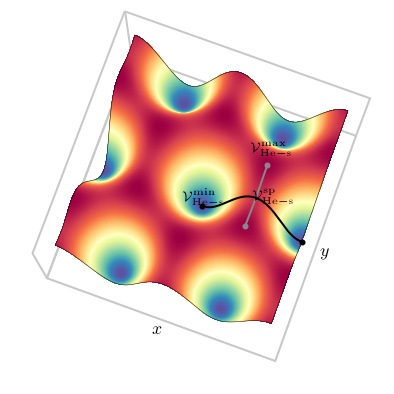

In [214]:
left_wall_text=r'$\overline{\mathcal{V}}_{\rm He-\graphene}$'
test_3D_wall_text(plot_filename="../plots/tunneling_steele.pdf", xlabel=r'$y$', ylabel=r'$x$', 
                  labelpad=[-17.0,-17.0,-14.0], mplstylefile=plot_style['aps'],
                 left_wall_text_size = 0.75,right_wall_text_size = 1)

### Perspective Combined Version

In [52]:
aₒ = 1.42
X = np.linspace(-aₒ*np.sqrt(3), aₒ*np.sqrt(3), 501)
Y = np.linspace(-aₒ*np.sqrt(3), aₒ*np.sqrt(3), 501)
X, Y = np.meshgrid(X, Y)
Vs = V(X,Y)

### Tunneling Paths ###################################
t1 = np.linspace(0,a[0,1]-0.05,1000)
t2 = np.linspace(0,a[1,1]+0.05,1000)
t = np.linspace(0,aₒ*np.sqrt(3),1000)
zs = V(t,np.zeros_like(t))

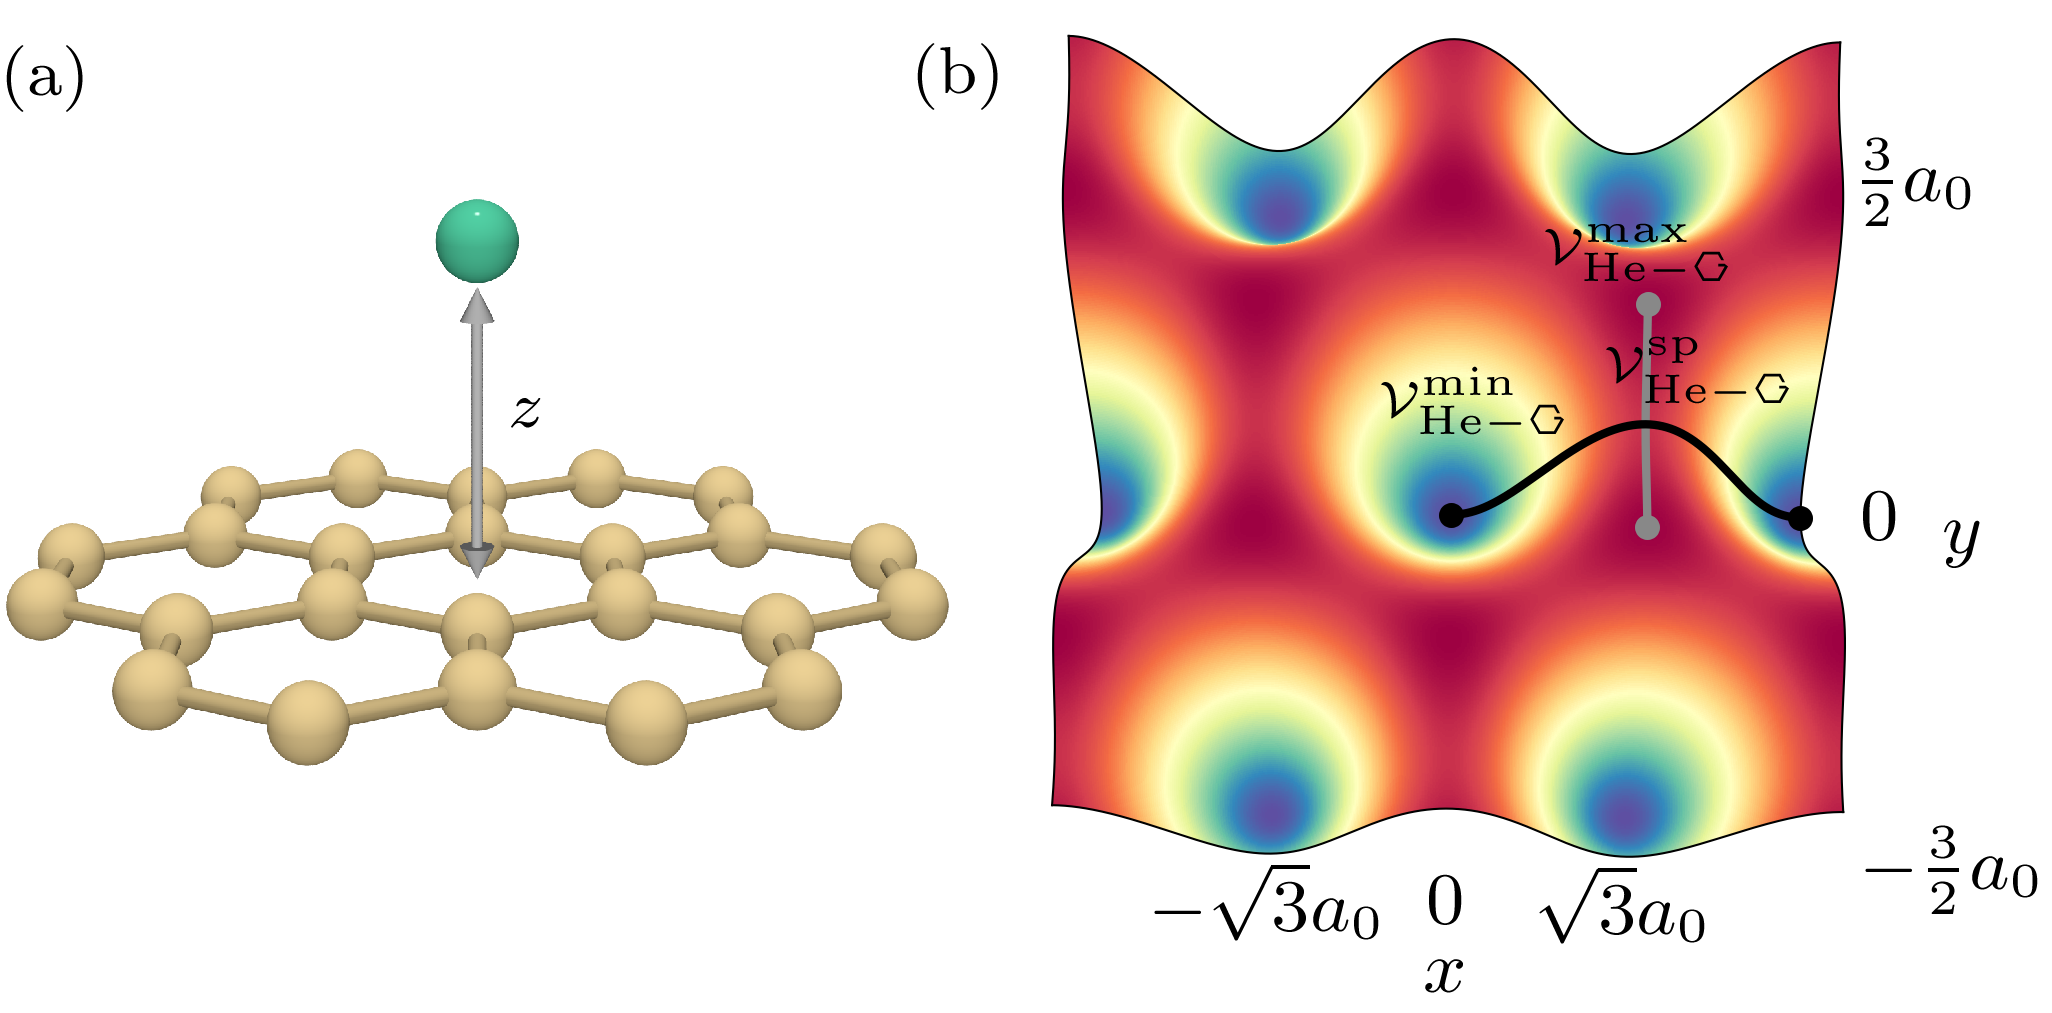

In [53]:
with plt.style.context(plot_style['aps']): 
    fig = plt.figure(figsize=(4.1,3.3),dpi=300, constrained_layout=False)
    
    ax_a = fig.add_subplot(121)
    
    im = plt.imread('../plots/V_He_graphene_green.png',format='png')
    #newax2 = fig.add_axes([0.12+0.3, 0.62, 0.28*w2/w1, 1.2])
    ax_a.imshow(np.pad(im, ((10,0),(0,10),(0,0))),interpolation='none', zorder=-10)
    ax_a.annotate('(a)', xy=(0.00,1.26),ha='left', va='top', xycoords='axes fraction', fontsize=8)
    ax_a.annotate('$z$', xy=(0.55,0.62),ha='center', va='center', xycoords='axes fraction', fontsize=8)

    ax_a.axis('off')
    
    ax = fig.add_subplot(122, projection='3d')

    _surf_kwargs = {"cmap":"Spectral_r", "linewidth":0, "antialiased":False, 
                            "alpha":1.0, 'rasterized':True}
    surf = ax.plot_surface(Y, X, Vs, rstride=1, cstride=1,zorder=-1, **_surf_kwargs)

    ### Tunneling Paths ###################################
    t1 = np.linspace(0,a[0,1]-0.05,1000)
    t2 = np.linspace(0,a[1,1]+0.05,1000)
    t = np.linspace(0,aₒ*np.sqrt(3),1000)
    zs = V(t,np.zeros_like(t))
    ax.plot(np.zeros_like(t),t,zs, color='k', lw=1, ls='-', alpha=1, zorder=10, zdir='z')

    t = np.linspace(-aₒ/2,aₒ/2,1000)
    zs = V(aₒ*np.sqrt(3)/2,t)
    ax.plot(t,aₒ*np.sqrt(3)/2*np.ones_like(t),zs, lw=1, ls='-', alpha=1, 
            zorder=9, zdir='z', color=grey)

    ### Special Points #####################################
    ax.plot([0,0],[0,aₒ*np.sqrt(3)],[V(0,0),V(0,0)], lw=0, marker='o', mfc='k', linestyle=None, alpha=1, 
            zorder=10, zdir='z', color='k', markersize=2)

    ax.plot([t[0],t[-1]],[aₒ*np.sqrt(3)/2,aₒ*np.sqrt(3)/2],[zs[-1],zs[-1]], lw=0, marker='o', mfc=grey, linestyle=None, alpha=1, 
            zorder=10, zdir='z', color=grey, markersize=2)


    ## Create an outline ####################################
    ax.plot(Y[:,0], X[:,0], Vs[:,0], lw=0.25, color='k', zorder=100)
    ax.plot(Y[:,-1], X[:,-1], Vs[:,-1], lw=0.25, color='k', zorder=100)

    ax.plot(Y[0,:], X[0,:], Vs[0,:], lw=0.25, color='k', zorder=100)
    ax.plot(Y[-1,:], X[-1,:], Vs[-1,:], lw=0.25, color='k', zorder=100)


    # Add labels
    ax.text(-0.7, -0.5, V(0,0), r'${\mathcal{V}}_{\rm He-\graphene}^{\rm min}$', color='k', 
            zorder=200, fontsize=6)
    ax.text(-b[0,0]+0.05, b[1,0]+0.5, 1.5, r'${\mathcal{V}}_{\rm He-\graphene}^{\rm max}$', color='k', 
            zorder=200, ha='center', fontsize=6)

    ax.text(-0.4, b[1,0]+0.9, 1.6, r'${\mathcal{V}}_{\rm He-\graphene}^{\rm sp}$', color='k', 
            zorder=200, ha='center', fontsize=6)

     # for rotated version
    _yticks = [-np.sqrt(3)*aₒ/2, 0.0,np.sqrt(3)*aₒ/2]
    _xticks = [-np.sqrt(3)*aₒ, 0.0,np.sqrt(3)*aₒ]

    ax.set_xticks(_xticks) 
    ax.set_yticks(_yticks) 
    ax.set_zticks([])
    
    # for rotated version
    _yticklabels = [r'$\frac{{3}}{2}a_0$', '$0$', r'$-\frac{{3}}{2}a_0$']
    _xticklabels = [r'$-\sqrt{3}a_0$', '$0$', r'$\sqrt{3}a_0$']

    ax.set_xticklabels(_yticklabels)
    ax.set_yticklabels(_xticklabels)
    ax.set_zticklabels([])

    ax.xaxis.set_tick_params(pad=-7, color='w')
    ax.yaxis.set_tick_params(pad=-11, color='w')
    ax.set_xlabel(r'$y$', labelpad=-12)
    ax.set_ylabel(r'$x$', labelpad=-17)


    for tick in ax.xaxis.get_majorticklabels():
        tick.set_verticalalignment("center")
        tick.set_horizontalalignment("left")

    ax.grid(False)
    
    pane_edge_color="None"
    pane_face_color="None"
    #Set pane edge color
    ax.xaxis.pane.set_edgecolor(pane_edge_color)
    ax.yaxis.pane.set_edgecolor(pane_edge_color)
    ax.zaxis.pane.set_edgecolor(pane_edge_color)

    ax.w_xaxis.line.set_color(pane_edge_color)
    ax.w_yaxis.line.set_color(pane_edge_color)
    ax.w_zaxis.line.set_color(pane_edge_color)

    #Set pane face color
    ax.xaxis.pane.set_facecolor(pane_face_color)
    ax.yaxis.pane.set_facecolor(pane_face_color)
    ax.zaxis.pane.set_facecolor(pane_face_color)

    ax.xaxis.pane.set_alpha(1)
    ax.yaxis.pane.set_alpha(1)
    ax.zaxis.pane.set_alpha(1)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.view_init(azim=0.5,elev=80.5)
    ax.annotate('(b)', xy=(-0.05,0.96),ha='left', va='top', xycoords='axes fraction', fontsize=8)
    
    #ax.axis('off')

    ax.xaxis._axinfo['tick']['outward_factor'] = 0.0
    ax.xaxis._axinfo['tick']['inward_factor'] = 0.0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0.0
    
    ax.dist = 7.2
    fig.subplots_adjust(wspace=0.01)
    
    plt.savefig('../plots/He_graphene_potential_combined.pdf', dpi=300)